<a href="https://colab.research.google.com/github/fuentes145/Tarea2/blob/main/Parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. DINOv2 Sparse Feature Matching and Linear Classifier


## Actividad 8:

La curación del conjunto de datos LVD-142M es un componente fundamental en el éxito del modelo DINOv2. Este proceso no fue manual, sino que consistió en una canalización automatizada, diseñada para seleccionar 142 millones de imágenes de alta calidad a partir de un repositorio web masivo. A continuación, se detalla cada etapa de este proceso:

1. **Inicio con imágenes semilla curadas:** El proceso comenzó utilizando imágenes provenientes de conjuntos de datos bien establecidos y de alta calidad como ImageNet-22k, ImageNet-1k y Google Landmarks. Estas imágenes actuaron como ejemplos representativos del tipo de calidad y diversidad visual que se buscaba. Esta selección inicial fue clave para dirigir el proceso hacia datos relevantes desde el comienzo.

2. **Recuperación de vecinos visuales:** Utilizando un modelo de visión autosupervisado previamente entrenado, se calcularon los embeddings de las imágenes semilla y de un repositorio mucho más amplio de 1.2 mil millones de imágenes web sin curar. Luego, se seleccionaron las imágenes del repositorio con embeddings más similares a los de las imágenes semilla, mediante una métrica de similitud como el coseno. Esta etapa permitió extraer imágenes visualmente relevantes sin necesidad de etiquetas o texto.

3. **Clustering para organización semántica:** Las imágenes recuperadas fueron agrupadas utilizando técnicas de clustering, como k-means. Esto permitió estructurar el conjunto de imágenes en grupos visualmente coherentes, facilitando el análisis de su diversidad y distribución semántica.

4. **Muestreo estratégico:** En lugar de incluir todas las imágenes recuperadas, se realizó un muestreo cuidadoso desde distintos clusters y regiones del espacio de embeddings. Esta selección buscó asegurar una cobertura amplia de dominios visuales, evitando sesgos y promoviendo un equilibrio conceptual en el conjunto final.

5. **Deduplicación rigurosa:** Se eliminaron imágenes duplicadas o casi idénticas, una práctica esencial para evitar redundancias que podrían perjudicar el aprendizaje del modelo. Además, se aseguró que ninguna imagen del conjunto de evaluación estuviera presente en el conjunto de entrenamiento, previniendo fugas de información.

Este proceso automatizado fue suficientemente eficiente como para completarse en menos de dos días. En conjunto, permitió construir un conjunto de datos masivo, diverso y conceptualmente balanceado, lo que fue determinante en la efectividad del modelo. Según los autores, la calidad de este conjunto de datos fue tan crítica como el diseño del algoritmo de entrenamiento en el éxito final de DINOv2.


## Actividad 9

Sparse matching es una técnica para encontrar correspondencias entre puntos clave de dos imágenes usando una cantidad limitada de descriptores visuales. En lugar de comparar todas las regiones posibles (dense matching), sparse matching se enfoca en comparar solo ciertos puntos relevantes, lo que lo hace más eficiente. En modelos como DINOv2, estos puntos se extraen automáticamente y se usan para emparejar regiones similares entre imágenes, incluso si hay cambios de iluminación, escala o ángulo.

In [ ]:
!pip install torch torchvision timm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import timm
import cv2
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from matplotlib.patches import ConnectionPatch
import math


In [ ]:
# Processor preprocesa imagenes para el modelo
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small', use_fast = True)
model = AutoModel.from_pretrained('facebook/dinov2-small')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06,

In [ ]:
def extract_features(model, image_tensor):
    # Features para clasificador lineal
    outputs = model(**image_tensor)
    last_hidden_states = outputs.last_hidden_state
    sequence_output = outputs[0]
    cls_token = sequence_output[:, 0]
    patch_tokens = sequence_output[:, 1:]
    patch_tokens_mean = patch_tokens.mean(dim=1)
    linear_input = torch.cat([cls_token, patch_tokens_mean], dim=1)
    return linear_input

def extract_patch_features(model, image_tensor, device='cuda'):
    # Features para sparse matching
    with torch.inference_mode():
        outputs = model(**image_tensor, output_hidden_states=True)
        hidden = outputs.hidden_states[-2]  # shape: [1, seq_len, hidden_dim]
        patch_tokens = hidden[:, 1:, :]        # exclude CLS token
    return patch_tokens.squeeze(0).cpu()

def get_patch_coords(num_patches):
    side = int(np.sqrt(num_patches))
    coords = np.stack(np.meshgrid(np.arange(side), np.arange(side)), axis=-1)
    return coords.reshape(-1, 2) * 16  # assuming 16×16 px per patch

def visualize_matches(img1, kp1, img2, kp2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    for i, j in matches:
        if i >= len(kp1) or j >= len(kp2):
            continue
        pt1 = tuple(np.round(kp1[i][::-1]).astype(int))  # (x, y)
        pt2 = tuple(np.round(kp2[j][::-1]).astype(int) + np.array([w1, 0]))
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.line(canvas, pt1, pt2, color, 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

def patch_idx_to_image_coords(idx, grid_size, resize_scale):
    h, w = grid_size
    row = idx // w
    col = idx % w
    patch_size = 16

    # Si resize_scale es un escalar, se aplica igual a x e y
    if isinstance(resize_scale, (int, float)):
        sx = sy = resize_scale
    else:
        sx, sy = resize_scale

    x = (col + 0.5) * patch_size * sx
    y = (row + 0.5) * patch_size * sy
    return (x, y)


def visualize_sparse_patch_matches(img1, img2, match1to2, grid_size1, grid_size2, resize_scale1=1.0, resize_scale2=1.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    ax1.imshow(img1)
    ax1.axis('off')
    ax2.imshow(img2)
    ax2.axis('off')
    print(f"Cantidad de matches recibidos: {len(match1to2)}")

    for idx1, idx2 in enumerate(match1to2):

        if np.random.rand() > 0.05:
            continue  # sparsify for clarity

        xyA = patch_idx_to_image_coords(idx1, grid_size1, resize_scale1)
        xyB = patch_idx_to_image_coords(idx2, grid_size2, resize_scale2)

        con = ConnectionPatch(xyA=xyB, coordsA="data", axesA=ax2,
                              xyB=xyA, coordsB="data", axesB=ax1,
                              color=np.random.rand(3,), linewidth=1)
        ax2.add_artist(con)
        print(f"Match {idx1}: img1 → {xyA}, img2 → {xyB}")

    plt.tight_layout()
    plt.show()

def compute_pca_mask(patch_tokens, grid_size=(16, 16), image_size=224):
    """
    Args:
        patch_tokens: [num_patches, dim]
    Returns:
        patch_mask: (h, w) PCA in patch space
        img_mask: (image_size, image_size) upsampled to image space
    """
    pca = PCA(n_components=1)
    mask = pca.fit_transform(patch_tokens.numpy())  # [num_patches, 1]
    mask = (mask - mask.min()) / (mask.max() - mask.min())

    h, w = grid_size
    patch_mask = mask.reshape(h, w)

    img_mask = cv2.resize(patch_mask, (image_size, image_size), interpolation=cv2.INTER_CUBIC)

    return patch_mask, img_mask


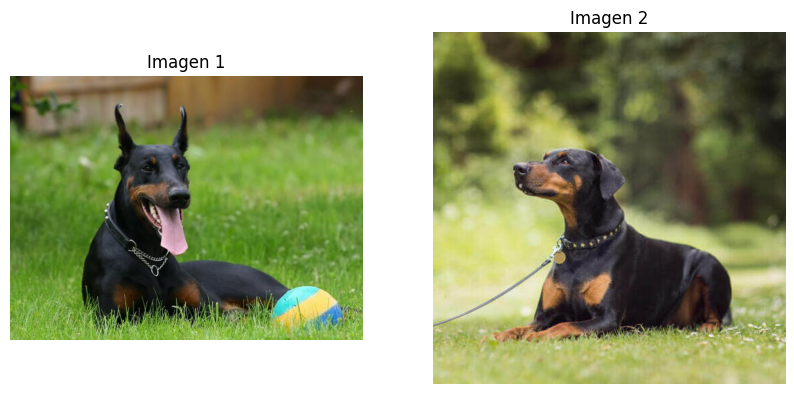

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Cargar imágenes
img1 = Image.open("doberman(3).jpg").convert("RGB")
img2 = Image.open("doberman(4).jpg").convert("RGB")

# Mostrar imágenes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1)
axs[0].set_title("Imagen 1")
axs[0].axis("off")
axs[1].imshow(img2)
axs[1].set_title("Imagen 2")
axs[1].axis("off")
plt.show()


In [ ]:
# Preprocesar y extraer descriptores de parche

# 1. Convertir las imágenes en tensores y moverlos al dispositivo
inputs1 = processor(images=img1, return_tensors="pt")
inputs2 = processor(images=img2, return_tensors="pt")
inputs1 = {k: v.to(device) for k, v in inputs1.items()}
inputs2 = {k: v.to(device) for k, v in inputs2.items()}

# 2. Extraer los descriptores por parche usando la función del notebook
patch_feats1 = extract_patch_features(model, inputs1, device)
patch_feats2 = extract_patch_features(model, inputs2, device)

# 3. Comprobar las dimensiones (número de parches, dimensión del embedding)
print(f"Shape de descriptores imagen 1: {patch_feats1.shape}")
print(f"Shape de descriptores imagen 2: {patch_feats2.shape}")


Shape de descriptores imagen 1: torch.Size([256, 384])
Shape de descriptores imagen 2: torch.Size([256, 384])


Cantidad de matches recibidos: 256
Match 54: img1 → (278.57142857142856, 112.50000000000001), img2 → (np.float64(236.7857142857143), np.float64(163.92857142857144))
Match 58: img1 → (449.99999999999994, 112.50000000000001), img2 → (np.float64(54.642857142857146), np.float64(382.5))
Match 80: img1 → (21.428571428571427, 176.7857142857143), img2 → (np.float64(18.214285714285715), np.float64(346.0714285714286))
Match 85: img1 → (235.7142857142857, 176.7857142857143), img2 → (np.float64(200.35714285714286), np.float64(200.35714285714286))
Match 145: img1 → (64.28571428571428, 305.3571428571429), img2 → (np.float64(346.0714285714286), np.float64(346.0714285714286))
Match 203: img1 → (492.85714285714283, 401.78571428571433), img2 → (np.float64(418.92857142857144), np.float64(382.5))
Match 234: img1 → (449.99999999999994, 466.0714285714286), img2 → (np.float64(491.78571428571433), np.float64(528.2142857142858))


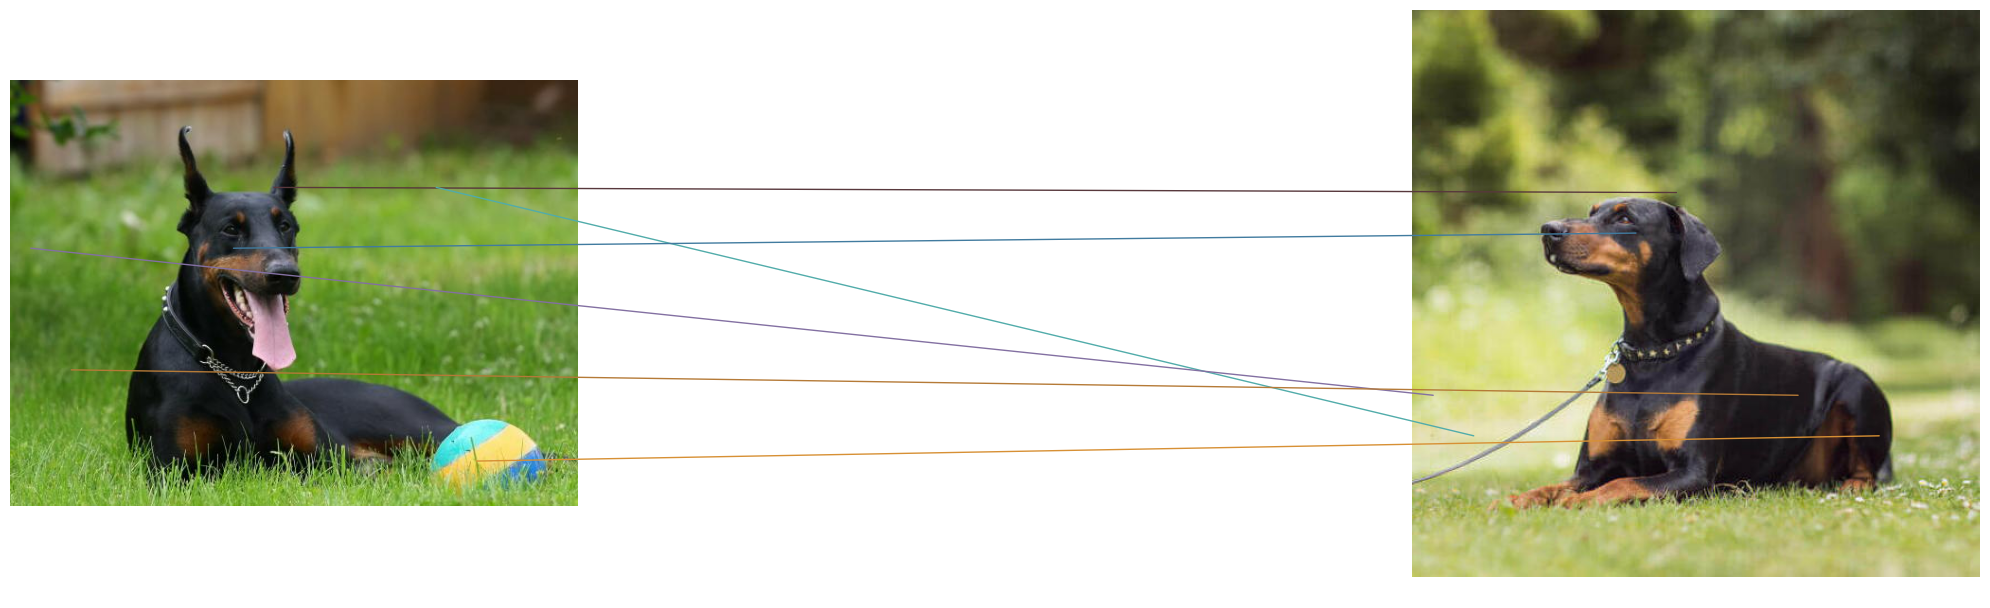

In [ ]:
import torch
import math

# 1. Emparejamiento: calcular distancias Euclídeas y encontrar el parche más cercano
dists = torch.cdist(patch_feats1, patch_feats2)          # shape [num_patches1, num_patches2]
match1to2 = dists.argmin(dim=1).cpu().numpy()           # para cada parche de img1, índice del parche más cercano en img2

# 2. Definir tamaños de grid (asumimos square grid)
grid_size1 = int(math.sqrt(patch_feats1.shape[0]))
grid_size2 = int(math.sqrt(patch_feats2.shape[0]))

# 3. Visualizar al menos 10 correspondencias con la función entregada
# ----------- FACTORES DE ESCALA -----------
# ancho_original / 224 , alto_original / 224
scale1 = (img1.size[0] / 224, img1.size[1] / 224)  # (sx, sy) para la 1ª imagen
scale2 = (img2.size[0] / 224, img2.size[1] / 224)  # (sx, sy) para la 2ª imagen

# ----------- GRID (16 x 16) -----------
grid = (16, 16)          # mismo para ambas imágenes (256 parches)

# ----------- VISUALIZAR -----------
visualize_sparse_patch_matches(
    img1, img2,
    match1to2,
    grid,                # grid_size1
    grid,                # grid_size2
    resize_scale1=scale1,
    resize_scale2=scale2
)



###Ahora vamos a rotar la imagen 2

Cantidad de matches recibidos: 256
Match 15: img1 → (664.2857142857142, 16.071428571428573), img2 → (np.float64(418.92857142857144), np.float64(163.92857142857144))
Match 49: img1 → (64.28571428571428, 112.50000000000001), img2 → (np.float64(163.92857142857144), np.float64(455.3571428571429))
Match 54: img1 → (278.57142857142856, 112.50000000000001), img2 → (np.float64(236.7857142857143), np.float64(236.7857142857143))
Match 70: img1 → (278.57142857142856, 144.64285714285717), img2 → (np.float64(200.35714285714286), np.float64(273.2142857142857))
Match 80: img1 → (21.428571428571427, 176.7857142857143), img2 → (np.float64(236.7857142857143), np.float64(382.5))
Match 92: img1 → (535.7142857142857, 176.7857142857143), img2 → (np.float64(200.35714285714286), np.float64(418.92857142857144))
Match 108: img1 → (535.7142857142857, 208.92857142857144), img2 → (np.float64(236.7857142857143), np.float64(491.78571428571433))
Match 114: img1 → (107.14285714285714, 241.07142857142858), img2 → (np.f

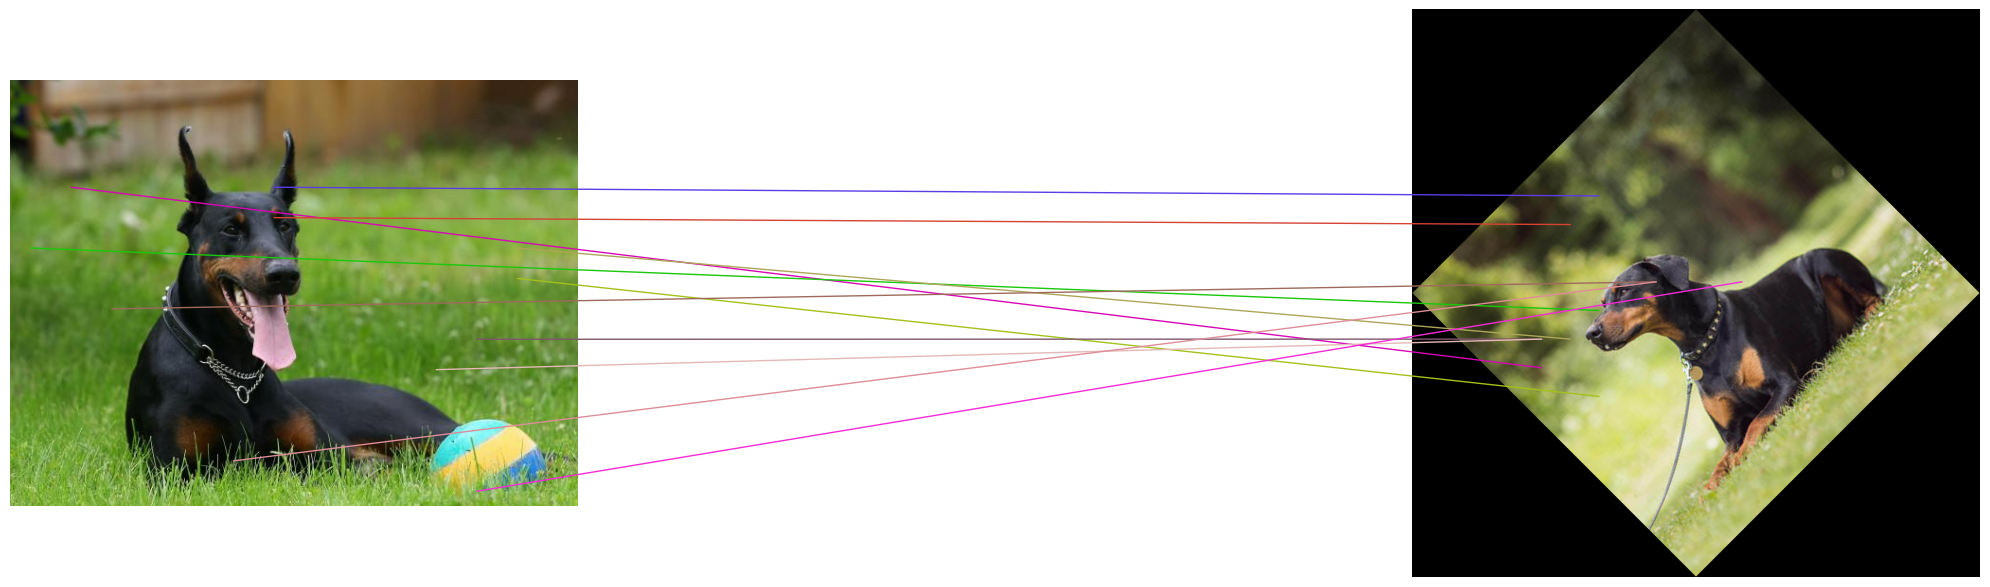

In [ ]:
from PIL import Image

# 1) Rota la segunda imagen y procésala
rotated_image2 = img2.rotate(45, resample=Image.BICUBIC, expand=True)
inputs2_rot = processor(images=rotated_image2, return_tensors="pt").to(device)

# 2) Extrae features de parches (idéntico al caso sin rotar)
patch_feats1 = extract_patch_features(model, inputs1)
patch_feats2_rot = extract_patch_features(model, inputs2_rot)

# 3) Calcula distancias y empareja con argmin (mismo que antes)
dists_rot = torch.cdist(patch_feats1, patch_feats2_rot)
match1to2_rot = dists_rot.argmin(dim=1).cpu().numpy()      # array shape [num_patches]

# 4) Visualiza usando la misma función que ya tienes definida
visualize_sparse_patch_matches(
    img1, rotated_image2,
    match1to2_rot,   # ahora sí le pasamos un array de índices
    grid,            # grid_size1 = (16,16)
    grid,            # grid_size2 = (16,16)
    resize_scale1=scale1,
    resize_scale2=scale2
)


Al rotar una de las imágenes, la precisión del sparse matching disminuye notablemente. Esto muestra que, aunque DINOv2 es robusto a muchos tipos de transformaciones, no es completamente invariante a la rotación, al menos sin reentrenamiento o ajustes adicionales.

## Actividad 10

In [ ]:
## 5. Linear Classifier with DINOv2 Features

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
])

train_data = datasets.CIFAR10(root='.', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='.', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, num_workers=2)

### Completar
##### Se recomienda tomar un subconjunto pequeño de imágenes (1000 train, 10 eval). #####